In [11]:
import ROOT
import uproot
import matplotlib.pyplot as plt
import numpy as np

Canale 0

In [3]:
channel = 0

In [4]:
#Tensione per considerare il segnale come saturato
Vt = np.array([-1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.5, -1.3, 
               -1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.3]) #V
#Carica per filtrare spike ed eventi triggerati male
Q_max = np.array([-30, -30, -30, -30, -30, -30, -30, -30, 
                  -30, -30, -30, -30, -30, -30, -30, -30, ]) #pC
#Carica per filtrare cosmici
Q_min = np.array([-1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, 
                  -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, ]) #pC

Vt = Vt[channel]
Q_max = Q_max[channel]
Q_min = Q_min[channel]

In [4]:
PATH = '../Dati/Dati_belli/Ch'+str(channel)+'/Run_ch' + str(channel) + '_Cs_Measurements_Only_4_3_2024_0000.root' #Percorso relativo del file da analizzare
RunCs = uproot.open(PATH) #Apertura file da analizzare

noise_file = '../Dati/Dati_belli/Ch'+str(channel)+'/Run_ch' + str(channel) + '_X_Measurements_Only_4_3_2024_0000.root'  #File di rumore di riferimento per il canale
RunNoise = uproot.open(noise_file)  #Apertura rumore

In [5]:
#Estrazione dati da file 

chargeCs = np.array(RunCs['tree'].arrays()['charge'])
ampCs = np.array(RunCs['tree'].arrays()['amp'])

chargeN = np.array(RunNoise['tree'].arrays()['charge'])
ampN = np.array(RunNoise['tree'].arrays()['amp'])

evCsT = np.array(RunCs['tree'].arrays()['ev'])[-1]
evNT = np.array(RunNoise['tree'].arrays()['ev'])[-1]
print(evCsT, evNT)

1000000 300000


In [6]:
trueCs = ampCs>Vt  #Seleziono solo gli eventi che non saturano
chargeCs = chargeCs[trueCs]
ampCs=ampCs[trueCs]

trueCs = (chargeCs < Q_max) & (chargeCs > Q_min)
chargeCs = chargeCs[trueCs] #Seleziono solo gli eventi con una carica sotto una certa soglia
ampCs=ampCs[trueCs]         #così da trascurare spike ed eventi dovuti a trigger su altro canale


trueX = ampN>Vt             #Procedo allo stesso modo per "ripulire" il rumore
chargeN = chargeN[trueX]
ampN=ampN[trueX]

trueX = (chargeN < Q_max) & (chargeN > Q_min)
chargeN = chargeN[trueX]
ampN=ampN[trueX]

print("#Eventi ripuliti su ch " + str(channel) + " = " + str(len(chargeCs)))
print("#Noise ripulita su ch " + str(channel) + " = " + str(len(chargeN)))

#Eventi ripuliti su ch 0 = 906223
#Noise ripulita su ch 0 = 246046


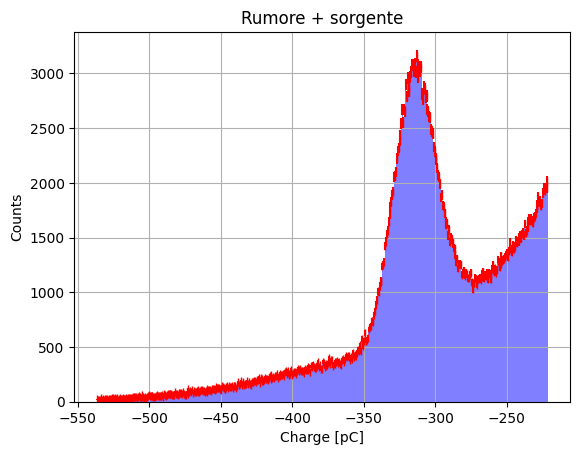

In [7]:
Nbin = 500
bin_lims = [int(Nbin *47 / 100), int(Nbin * 80/ 100)] #Scelgo gli estremi
_, edges, _ = plt.hist(chargeCs, bins = Nbin, color = "r")
plt.clf()
lims = [edges[bin_lims[0]], edges[bin_lims[1]]]
binCs, edgesCs, _ = plt.hist(chargeCs, bins = Nbin, range = lims, color = "b", alpha = 0.5)
centersCs = np.convolve(edgesCs, [0.5, 0.5], "valid")
errCs = np.sqrt(binCs)

plt.errorbar(centersCs, binCs, errCs, color = "red", fmt='|')
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("Counts")
plt.title("Rumore + sorgente")

plt.show()


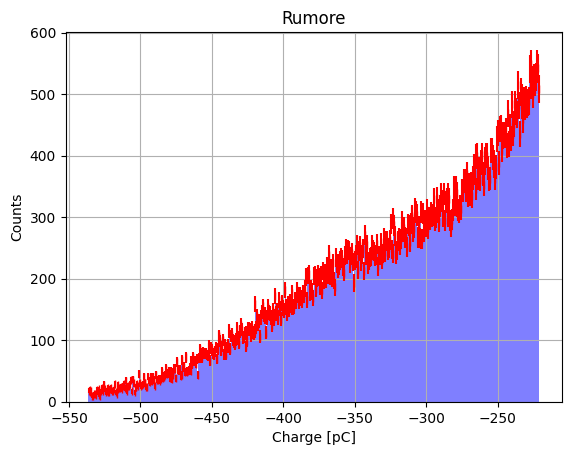

99761.0

In [8]:
binN, edgesN, _ = plt.hist(chargeN, bins = Nbin, range = lims, color = "b", alpha = 0.5)
centersN = np.convolve(edgesN, [0.5, 0.5], "valid")
errN = np.sqrt(binN)
plt.errorbar(centersN, binN, errN, color = "red", fmt='|')
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("Counts")
plt.title("Rumore")

plt.show()

binN.sum()


In [13]:
from lmfit import minimize, Parameters, Model
from lmfit.models import GaussianModel, ExponentialModel, \
                         ThermalDistributionModel #Modelli vari, l'ultimo è Fermi (o Bose)

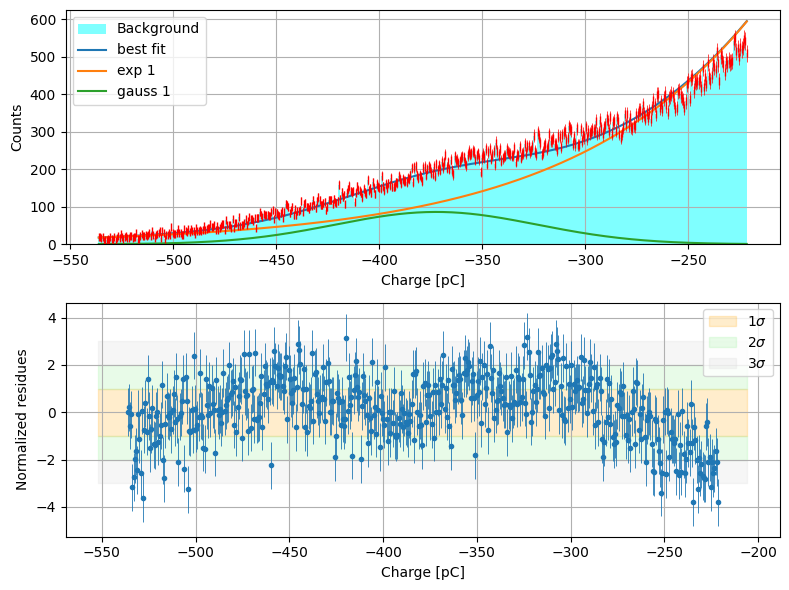

[[Model]]
    ((Model(exponential, prefix='e1_') + Model(gaussian, prefix='g1_')) + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 73
    # data points      = 500
    # variables        = 4
    chi-square         = 900.087895
    reduced chi-square = 1.81469334
    Akaike info crit   = 301.942161
    Bayesian info crit = 318.800593
    R-squared          = 0.99990895
[[Variables]]
    e1_amplitude:  7062.18297 +/- 260.022715 (3.68%) (init = 7397.938)
    e1_decay:     -89.4789640 +/- 1.16950415 (1.31%) (init = -94.96321)
    g1_amplitude:  10593.2745 +/- 390.034073 (3.68%) == '1.5*e1_amplitude'
    g1_center:    -372.346830 +/- 1.15302910 (0.31%) (init = -267.2123)
    g1_sigma:      49.0918422 +/- 1.38844657 (2.83%) (init = 51.72135)
    g1_fwhm:       115.602450 +/- 3.26954175 (2.83%) == '2.3548200*g1_sigma'
    g1_height:     86.0856948 +/- 2.18872136 (2.54%) == '0.3989423*g1_amplitude/max(1e-15, g1_sigma)'
    g2_amplitud

In [10]:
exp1   = ExponentialModel(prefix='e1_') #Esponenziale 
gauss1 = GaussianModel(prefix='g1_')    #Gaussiana
gauss2 = GaussianModel(prefix='g2_')    #Gaussiana
#fd1    = ThermalDistributionModel(form = "fermi", prefix = "fd1_") #Fermi Dirac

def Fermi_Dirac(x, fd_A, fd_B,fd_x0, fd_kt):
    # Calculate model values using the parameters
    model_values = fd_A/(1+fd_B*np.exp((x-fd_x0)/fd_kt))
    return model_values

fd1=Model(Fermi_Dirac)

 
params = exp1.guess(binN, x=centersN)           #Inizializzo i parametri dell'esponenziale
params.update(gauss1.guess(binN, x=centersN))   #Indovina i parametri della prima gaussiana
params.update(gauss2.make_params(amplitude = 0, center = -320, sigma = 25)) #Imposta la seconda gaussiana con A = 0 (necessario per primo fit)
#params.update(fd1.make_params(amplitude = 0, center = -200, kt =-0.01))     #Imposta la Fermi Dirac con A = 0 (necessario per primo fit)

params["g2_amplitude"].vary = False    #Blocco i parametri della seconda gaussiana e della 
params["g2_center"].vary = False       #Fermi Dirac: non servono nel primo fit
params["g2_sigma"].vary = False
params["g1_amplitude"].min=0
params["e1_amplitude"].min=0
frac=1.5
params["g1_amplitude"].expr=str(frac)+'*e1_amplitude'




model = exp1 + gauss1 + gauss2 #+ fd1     #Per ora non usiamo la Fermi Dirac at all

# Fit the model to the data
result = model.fit(binN, params, x = centersN, weights = 1/errN, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.hist(chargeN, bins = Nbin, range = lims, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(centersN, result.best_fit, label='best fit')
ax1.plot(centersN, comps['e1_'], label='exp 1')
ax1.plot(centersN, comps['g1_'], label='gauss 1')


ax1.legend()
ax1.errorbar(centersN, binN, errN, color = "red", fmt='|', linewidth=0.5)
ax1.grid()

residueN = binN - result.best_fit
norm_resN = residueN / errN

ax2.errorbar(centersN, norm_resN, 1, ls = "", marker = ".", linewidth=.6)
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()

# Print fit statistics and parameter values
print(result.fit_report())

frac=result.params["e1_amplitude"].value/result.params["g1_amplitude"].value
print(frac)
#params.update(result.params)

In [1]:

params["g1_sigma"].vary = False   #Blocco i parametri dell'esponenziale e della prima gaussiana
params["g1_center"].vary = False  #lasciando libere le ampiezze
params["e1_decay"].vary = False


params["g2_amplitude"].vary = True  #Sblocco i parametri di Fermi Dirac e seconda gaussiana
params["g2_center"].vary = True
params["g2_sigma"].vary = True



params["g2_amplitude"].value = 1000     #Parametri da aggiustare to make the magic happen
params["g2_center"].min = -350          #Si possono, se serve, specificare canale per canale
params["g2_center"].max = -250
params["g2_center"].set(value = -350)
params["g2_sigma"].set(value = 1)
params["g2_amplitude"].min=0
params["g1_amplitude"].min=0
params["e1_amplitude"].min=0
#params["e1_amplitude"].expr=str(frac)+'*g1_amplitude'


model = exp1 + gauss1 + gauss2 #+ fd1

#params.update(fd1.guess(binCs, x=centersCs)) #Aggiorno i parametri della seconda gaussiana indovinando
params.pretty_print()

start=int(Nbin *25 / 100)
stop=int(Nbin * 100/ 100)

# Fit the model to the data
result = model.fit(binCs[start:stop], params, x = centersCs[start:stop], weights = 1/errCs[start:stop])


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.hist(chargeCs, bins = Nbin, range = lims, color = "cyan", alpha = 0.5, label = "Dati sperimentali")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.errorbar(centersCs, binCs, errCs, color = "red", fmt='|', linewidth=.6)
ax1.plot(centersCs[start:stop], result.best_fit, label='best fit')
ax1.plot(centersCs[start:stop], comps['e1_'], label='exp 1')
ax1.plot(centersCs[start:stop], comps['g1_'], label='gauss 1')
ax1.plot(centersCs[start:stop], comps['g2_'], label='gauss 2')
#ax1.plot(centersCs[start:stop], comps['Fermi_Dirac'], label='fd1')


ax1.legend()
ax1.grid()

residueCs = binCs[start:stop] - result.best_fit
norm_resCs = residueCs / errCs[start:stop]

ax2.errorbar(centersCs[start:stop], norm_resCs, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()

# Print fit statistics and parameter values
print(result.fit_report())



NameError: name 'params' is not defined

Canale 1. Vincolato

In [313]:
channel = 1

In [314]:
#Tensione per considerare il segnale come saturato
Vt = np.array([-1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.5, -1.3, 
               -1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.3]) #V
#Carica per filtrare spike ed eventi triggerati male
Q_max = np.array([-30, -30, -30, -30, -30, -30, -30, -30, 
                  -30, -30, -30, -30, -30, -30, -30, -30, ]) #pC
#Carica per filtrare cosmici
Q_min = np.array([-1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, 
                  -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, ]) #pC

Vt = Vt[channel]
Q_max = Q_max[channel]
Q_min = Q_min[channel]

In [315]:
#Tensione per considerare il segnale come saturato
Vt = np.array([-1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.5, -1.3, 
               -1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.3]) #V
#Carica per filtrare spike ed eventi triggerati male
Q_max = np.array([-30, -30, -30, -30, -30, -30, -30, -30, 
                  -30, -30, -30, -30, -30, -30, -30, -30, ]) #pC
#Carica per filtrare cosmici
Q_min = np.array([-1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, 
                  -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, ]) #pC

Vt = Vt[channel]
Q_max = Q_max[channel]
Q_min = Q_min[channel]

In [ ]:
PATH = '../Dati/Dati_belli/Ch'+str(channel)+'/Run_ch' + str(channel) + '_Cs_Measurements_Only_4_4_2024_0000.root' #Percorso relativo del file da analizzare
RunCs = uproot.open(PATH) #Apertura file da analizzare

noise_file = '../Dati/Dati_belli/Ch'+str(channel)+'/Run_ch' + str(channel) + '_X_Measurements_Only_4_4_2024_0000.root'  #File di rumore di riferimento per il canale
RunNoise = uproot.open(noise_file)  #Apertura rumore

In [133]:
#Estrazione dati da file 

chargeCs = np.array(RunCs['tree'].arrays()['charge'])
ampCs = np.array(RunCs['tree'].arrays()['amp'])

chargeN = np.array(RunNoise['tree'].arrays()['charge'])
ampN = np.array(RunNoise['tree'].arrays()['amp'])

evCsT = np.array(RunCs['tree'].arrays()['ev'])[-1]
evNT = np.array(RunNoise['tree'].arrays()['ev'])[-1]
print(evCsT, evNT)

100000 100000


In [134]:
trueCs = ampCs>Vt  #Seleziono solo gli eventi che non saturano
chargeCs = chargeCs[trueCs]
ampCs=ampCs[trueCs]

trueCs = (chargeCs < Q_max) & (chargeCs > Q_min)
chargeCs = chargeCs[trueCs] #Seleziono solo gli eventi con una carica sotto una certa soglia
ampCs=ampCs[trueCs]         #così da trascurare spike ed eventi dovuti a trigger su altro canale


trueX = ampN>Vt             #Procedo allo stesso modo per "ripulire" il rumore
chargeN = chargeN[trueX]
ampN=ampN[trueX]

trueX = (chargeN < Q_max) & (chargeN > Q_min)
chargeN = chargeN[trueX]
ampN=ampN[trueX]

print("#Eventi ripuliti su ch " + str(channel) + " = " + str(len(chargeCs)))
print("#Noise ripulita su ch " + str(channel) + " = " + str(len(chargeN)))

#Eventi ripuliti su ch 1 = 88869
#Noise ripulita su ch 1 = 77250


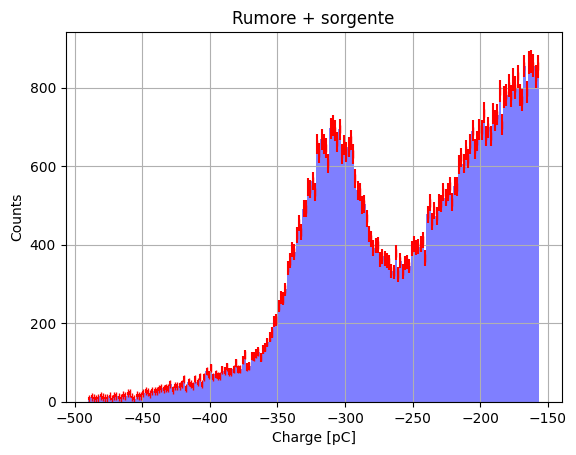

In [135]:
Nbin = 200
bin_lims = [int(Nbin *45 / 100), int(Nbin * 85 / 100)] #Scelgo gli estremi
_, edges, _ = plt.hist(chargeCs, bins = Nbin, color = "r")
plt.clf()
lims = [edges[bin_lims[0]], edges[bin_lims[1]]]
binCs, edgesCs, _ = plt.hist(chargeCs, bins = Nbin, range = lims, color = "b", alpha = 0.5)
centersCs = np.convolve(edgesCs, [0.5, 0.5], "valid")
errCs = np.sqrt(binCs)

plt.errorbar(centersCs, binCs, errCs, color = "red", fmt='|')
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("Counts")
plt.title("Rumore + sorgente")

plt.show()


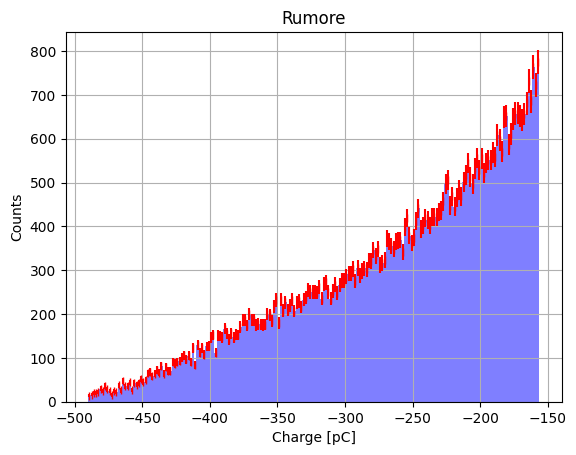

55951.0

In [136]:
binN, edgesN, _ = plt.hist(chargeN, bins = Nbin, range = lims, color = "b", alpha = 0.5)
centersN = np.convolve(edgesN, [0.5, 0.5], "valid")
errN = np.sqrt(binN)
plt.errorbar(centersN, binN, errN, color = "red", fmt='|')
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("Counts")
plt.title("Rumore")

plt.show()

binN.sum()

In [71]:
from lmfit import minimize, Parameters, Model
from lmfit.models import GaussianModel, ExponentialModel, \
                         ThermalDistributionModel #Modelli vari, l'ultimo è Fermi (o Bose)

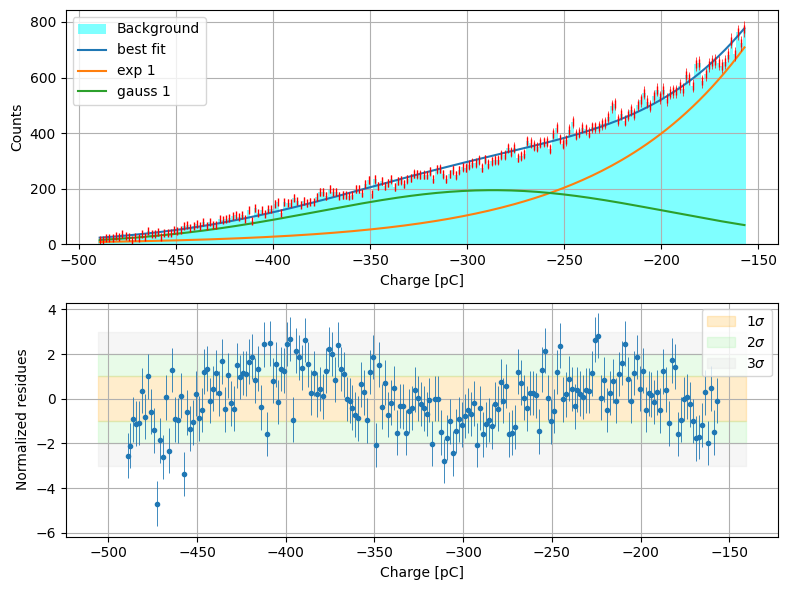

[[Model]]
    ((Model(exponential, prefix='e1_') + Model(gaussian, prefix='g1_')) + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 132
    # data points      = 200
    # variables        = 5
    chi-square         = 327.951381
    reduced chi-square = 1.68180196
    Akaike info crit   = 108.909601
    Bayesian info crit = 125.401188
    R-squared          = 0.99995652
[[Variables]]
    e1_amplitude:  5855.83062 +/- 2458.24283 (41.98%) (init = 4244.95)
    e1_decay:     -74.4160144 +/- 17.4638071 (23.47%) (init = -105.3998)
    g1_amplitude:  43838.4538 +/- 20209.4348 (46.10%) (init = 112366)
    g1_center:    -286.649554 +/- 20.3069346 (7.08%) (init = -203.3568)
    g1_sigma:      89.8990548 +/- 13.0563573 (14.52%) (init = 49.21857)
    g1_fwhm:       211.696089 +/- 30.7453713 (14.52%) == '2.3548200*g1_sigma'
    g1_height:     194.540575 +/- 61.6753099 (31.70%) == '0.3989423*g1_amplitude/max(1e-15, g1_sigma)'
    g2_amplitud

In [152]:
exp1   = ExponentialModel(prefix='e1_') #Esponenziale 
gauss1 = GaussianModel(prefix='g1_')    #Gaussiana
gauss2 = GaussianModel(prefix='g2_')    #Gaussiana
#fd1    = ThermalDistributionModel(form = "fermi", prefix = "fd1_") #Fermi Dirac

def Fermi_Dirac(x, fd_A, fd_B,fd_x0, fd_kt):
    # Calculate model values using the parameters
    model_values = fd_A/(1+fd_B*np.exp((x-fd_x0)/fd_kt))
    return model_values

fd1=Model(Fermi_Dirac)

 
params = exp1.guess(binN, x=centersN)           #Inizializzo i parametri dell'esponenziale
params.update(gauss1.guess(binN, x=centersN))   #Indovina i parametri della prima gaussiana
params.update(gauss2.make_params(amplitude = 0, center = -320, sigma = 25)) #Imposta la seconda gaussiana con A = 0 (necessario per primo fit)
#params.update(fd1.make_params(amplitude = 0, center = -200, kt =-0.01))     #Imposta la Fermi Dirac con A = 0 (necessario per primo fit)

params["g2_amplitude"].vary = False    #Blocco i parametri della seconda gaussiana e della 
params["g2_center"].vary = False       #Fermi Dirac: non servono nel primo fit
params["g2_sigma"].vary = False

""""
params.update(fd1.make_params(fd_A=200, fd_B=1, fd_x0=-200, fd_kt=-0.01))
params["fd_A"].vary = False
params["fd_B"].vary = False
params["fd_x0"].vary = False
params["fd_kt"].vary = False
params["fd1_amplitude"].vary = False
params["fd1_center"].vary = False
params["fd1_kt"].vary = False
"""



model = exp1 + gauss1 + gauss2 #+ fd1     #Per ora non usiamo la Fermi Dirac at all

# Fit the model to the data
result = model.fit(binN, params, x = centersN, weights = 1 / errN, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.hist(chargeN, bins = Nbin, range = lims, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(centersN, result.best_fit, label='best fit')
ax1.plot(centersN, comps['e1_'], label='exp 1')
ax1.plot(centersN, comps['g1_'], label='gauss 1')


ax1.legend()
ax1.errorbar(centersN, binN, errN, color = "red", fmt='|', linewidth=0.5)
ax1.grid()

residueN = binN - result.best_fit
norm_resN = residueN / errN

ax2.errorbar(centersN, norm_resN, 1, ls = "", marker = ".", linewidth=.6)
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()

# Print fit statistics and parameter values
print(result.fit_report())

frac=result.params["e1_amplitude"].value/result.params["g1_amplitude"].value
print(frac)

Name             Value      Min      Max   Stderr     Vary     Expr Brute_Step
e1_amplitude  1.501e+04        0      inf     None    False 0.13357748994456417*g1_amplitude     None
e1_decay        -105.4     -inf      inf     None    False     None     None
g1_amplitude  1.124e+05        0      inf     None     True     None     None
g1_center       -203.4     -inf      inf     None    False     None     None
g1_fwhm          115.9     -inf      inf     None    False 2.3548200*g1_sigma     None
g1_height        910.8     -inf      inf     None    False 0.3989423*g1_amplitude/max(1e-15, g1_sigma)     None
g1_sigma         49.22        0      inf     None    False     None     None
g2_amplitude      1000        0      inf     None     True     None     None
g2_center         -350     -400     -300     None     True     None     None
g2_fwhm          2.355     -inf      inf     None    False 2.3548200*g2_sigma     None
g2_height        398.9     -inf      inf     None    False 0.3989423*g

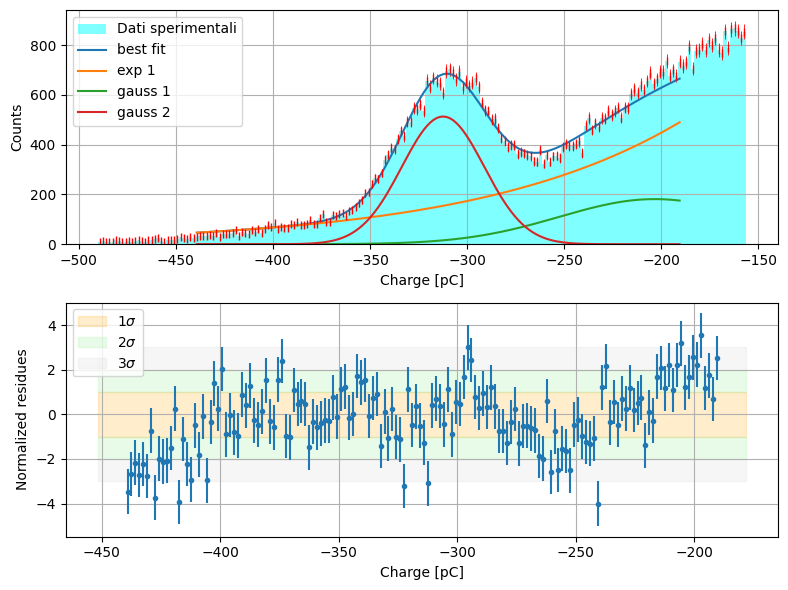

[[Model]]
    ((Model(exponential, prefix='e1_') + Model(gaussian, prefix='g1_')) + Model(gaussian, prefix='g2_'))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 61
    # data points      = 150
    # variables        = 4
    chi-square         = 352.718795
    reduced chi-square = 2.41588216
    Akaike info crit   = 136.255374
    Bayesian info crit = 148.297916
    R-squared          = 0.99995642
[[Variables]]
    e1_amplitude:  2988.52433 +/- 30.3070772 (1.01%) == '0.13357748994456417*g1_amplitude'
    e1_decay:     -105.3998 (fixed)
    g1_amplitude:  22372.9637 +/- 226.887608 (1.01%) (init = 112366)
    g1_center:    -203.3568 (fixed)
    g1_sigma:      49.21857 (fixed)
    g1_fwhm:       115.900866 +/- 0.00000000 (0.00%) == '2.3548200*g1_sigma'
    g1_height:     181.344606 +/- 1.83904306 (1.01%) == '0.3989423*g1_amplitude/max(1e-15, g1_sigma)'
    g2_amplitude:  27295.5681 +/- 495.569107 (1.82%) (init = 1000)
    g2_center:    -312.362150 +/- 0.40543

In [154]:
params["g1_sigma"].vary = False   #Blocco i parametri dell'esponenziale e della prima gaussiana
params["g1_center"].vary = False  #lasciando libere le ampiezze
params["e1_decay"].vary = False

params["g2_amplitude"].vary = True  #Sblocco i parametri di Fermi Dirac e seconda gaussiana
params["g2_center"].vary = True
params["g2_sigma"].vary = True

#params["fd1_amplitude"].vary = True
#params["fd1_center"].vary = True
#params["fd1_kt"].vary = True


params["g2_amplitude"].value = 1000     #Parametri da aggiustare to make the magic happen
params["g2_center"].min = -400          #Si possono, se serve, specificare canale per canale
params["g2_center"].max = -300
params["g2_center"].set(value = -350)
params["g2_sigma"].set(value = 1)
params["g2_amplitude"].min=0
params["g1_amplitude"].min=0
params["e1_amplitude"].min=0
params["e1_amplitude"].expr=str(frac)+'*g1_amplitude'

"""
params["fd_A"].vary = True
params["fd_B"].vary = True
params["fd_x0"].vary = True
params["fd_kt"].vary = True
params["fd_A"].min=0
params["fd_A"].max=1000
params["fd_kt"].max=0
params["fd_x0"].min=-400
params["fd_x0"].max=-100
"""
model = exp1 + gauss1 + gauss2 #+ fd1

#params.update(fd1.guess(binCs, x=centersCs)) #Aggiorno i parametri della seconda gaussiana indovinando
params.pretty_print()

start=int(Nbin *15 / 100)
stop=int(Nbin * 90/ 100)

# Fit the model to the data
result = model.fit(binCs[start:stop], params, x = centersCs[start:stop], weights = 1 / errCs[start:stop])


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.hist(chargeCs, bins = Nbin, range = lims, color = "cyan", alpha = 0.5, label = "Dati sperimentali")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.errorbar(centersCs, binCs, errCs, color = "red", fmt='|', linewidth=.6)
ax1.plot(centersCs[start:stop], result.best_fit, label='best fit')
ax1.plot(centersCs[start:stop], comps['e1_'], label='exp 1')
ax1.plot(centersCs[start:stop], comps['g1_'], label='gauss 1')
ax1.plot(centersCs[start:stop], comps['g2_'], label='gauss 2')
#ax1.plot(centersCs[start:stop], comps['Fermi_Dirac'], label='fd1')


ax1.legend()
ax1.grid()

residueCs = binCs[start:stop] - result.best_fit
norm_resCs = residueCs / errCs[start:stop]

ax2.errorbar(centersCs[start:stop], norm_resCs, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()

# Print fit statistics and parameter values
print(result.fit_report())



In [155]:
frac2=result.params["e1_amplitude"].value/result.params["g1_amplitude"].value
print(frac2, params["e1_amplitude"].value, params["g1_amplitude"].value)

0.13357748994456417 15009.566661596764 112365.98822021484


Canale 2

In [6]:
channel = 2

In [7]:

#Tensione per considerare il segnale come saturato
Vt = np.array([-1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.5, -1.3, 
               -1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.3, -1.3]) #V
#Carica per filtrare spike ed eventi triggerati male
Q_max = np.array([-30, -30, -30, -30, -30, -30, -30, -30, 
                  -30, -30, -30, -30, -30, -30, -30, -30, ]) #pC
#Carica per filtrare cosmici
Q_min = np.array([-1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, 
                  -1000, -1000, -1000, -1000, -1000, -1000, -1000, -1000, ]) #pC

Vt = Vt[channel]
Q_max = Q_max[channel]
Q_min = Q_min[channel]
PATH = '../Dati/Dati_belli/Ch'+str(channel)+'/Run_ch' + str(channel) + '_Cs_Measurements_Only_3_27_2024.root' #Percorso relativo del file da analizzare
RunCs = uproot.open(PATH) #Apertura file da analizzare

noise_file = '../Dati/Dati_belli/Ch'+str(channel)+'/Run_ch' + str(channel) + '_X_Measurements_Only_4_5_2024_0000.root'  #File di rumore di riferimento per il canale
RunNoise = uproot.open(noise_file)  #Apertura rumore

1000000 500000
#Eventi ripuliti su ch 2 = 801505
#Noise ripulita su ch 2 = 256621


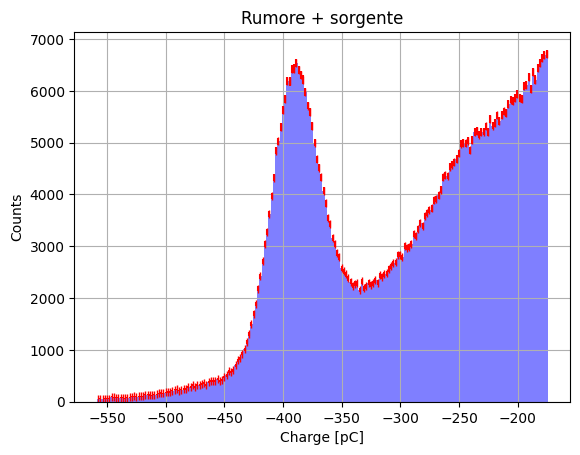

In [8]:
#Estrazione dati da file 

chargeCs = np.array(RunCs['tree'].arrays()['charge'])
ampCs = np.array(RunCs['tree'].arrays()['amp'])

chargeN = np.array(RunNoise['tree'].arrays()['charge'])
ampN = np.array(RunNoise['tree'].arrays()['amp'])

evCsT = np.array(RunCs['tree'].arrays()['ev'])[-1]
evNT = np.array(RunNoise['tree'].arrays()['ev'])[-1]
print(evCsT, evNT)
trueCs = ampCs>Vt  #Seleziono solo gli eventi che non saturano
chargeCs = chargeCs[trueCs]
ampCs=ampCs[trueCs]

trueCs = (chargeCs < Q_max) & (chargeCs > Q_min)
chargeCs = chargeCs[trueCs] #Seleziono solo gli eventi con una carica sotto una certa soglia
ampCs=ampCs[trueCs]         #così da trascurare spike ed eventi dovuti a trigger su altro canale


trueX = ampN>Vt             #Procedo allo stesso modo per "ripulire" il rumore
chargeN = chargeN[trueX]
ampN=ampN[trueX]

trueX = (chargeN < Q_max) & (chargeN > Q_min)
chargeN = chargeN[trueX]
ampN=ampN[trueX]

print("#Eventi ripuliti su ch " + str(channel) + " = " + str(len(chargeCs)))
print("#Noise ripulita su ch " + str(channel) + " = " + str(len(chargeN)))


Nbin = 200
bin_lims = [int(Nbin *45 / 100), int(Nbin * 85 / 100)] #Scelgo gli estremi
_, edges, _ = plt.hist(chargeCs, bins = Nbin, color = "r")
plt.clf()
lims = [edges[bin_lims[0]], edges[bin_lims[1]]]
binCs, edgesCs, _ = plt.hist(chargeCs, bins = Nbin, range = lims, color = "b", alpha = 0.5)
centersCs = np.convolve(edgesCs, [0.5, 0.5], "valid")
errCs = np.sqrt(binCs)

plt.errorbar(centersCs, binCs, errCs, color = "red", fmt='|')
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("Counts")
plt.title("Rumore + sorgente")

plt.show()


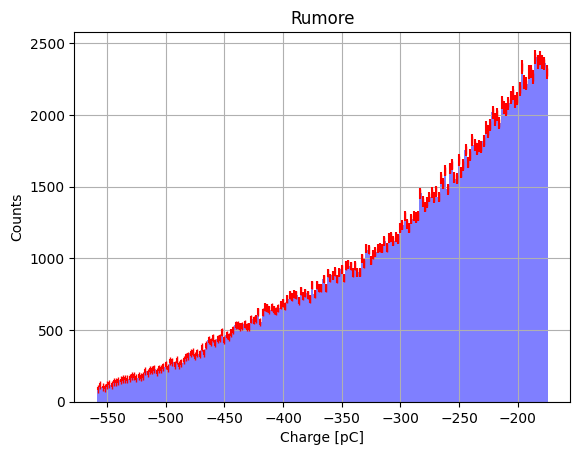

193729.0

In [9]:
binN, edgesN, _ = plt.hist(chargeN, bins = Nbin, range = lims, color = "b", alpha = 0.5)
centersN = np.convolve(edgesN, [0.5, 0.5], "valid")
errN = np.sqrt(binN)
plt.errorbar(centersN, binN, errN, color = "red", fmt='|')
plt.grid()
plt.xlabel("Charge [pC]")
plt.ylabel("Counts")
plt.title("Rumore")

plt.show()

binN.sum()

In [12]:
exp1   = ExponentialModel(prefix='e1_') #Esponenziale 
gauss1 = GaussianModel(prefix='g1_')    #Gaussiana
gauss2 = GaussianModel(prefix='g2_')    #Gaussiana
#fd1    = ThermalDistributionModel(form = "fermi", prefix = "fd1_") #Fermi Dirac

def Fermi_Dirac(x, fd_A, fd_B,fd_x0, fd_kt):
    # Calculate model values using the parameters
    model_values = fd_A/(1+fd_B*np.exp((x-fd_x0)/fd_kt))
    return model_values

fd1=Model(Fermi_Dirac)

 
params = exp1.guess(binN, x=centersN)           #Inizializzo i parametri dell'esponenziale
params.update(gauss1.guess(binN, x=centersN))   #Indovina i parametri della prima gaussiana
params.update(gauss2.make_params(amplitude = 0, center = -320, sigma = 25)) #Imposta la seconda gaussiana con A = 0 (necessario per primo fit)
#params.update(fd1.make_params(amplitude = 0, center = -200, kt =-0.01))     #Imposta la Fermi Dirac con A = 0 (necessario per primo fit)

params["g2_amplitude"].vary = False    #Blocco i parametri della seconda gaussiana e della 
params["g2_center"].vary = False       #Fermi Dirac: non servono nel primo fit
params["g2_sigma"].vary = False


params.update(fd1.make_params(fd_A=900, fd_B=1e-4, fd_x0=-250, fd_kt=-15))
params["fd_A"].vary = False
params["fd_B"].vary = False
params["fd_x0"].vary = False
params["fd_kt"].vary = False
"""
params["fd1_amplitude"].vary = False
params["fd1_center"].vary = False
params["fd1_kt"].vary = False
"""



model = exp1 + gauss1 + gauss2 #+ fd1     #Per ora non usiamo la Fermi Dirac at all

# Fit the model to the data
result = model.fit(binN, params, x = centersN, weights = 1 / errN, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.hist(chargeN, bins = Nbin, range = lims, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(centersN, result.best_fit, label='best fit')
ax1.plot(centersN, comps['e1_'], label='exp 1')
ax1.plot(centersN, comps['g1_'], label='gauss 1')


ax1.legend()
ax1.errorbar(centersN, binN, errN, color = "red", fmt='|', linewidth=0.5)
ax1.grid()

residueN = binN - result.best_fit
norm_resN = residueN / errN

ax2.errorbar(centersN, norm_resN, 1, ls = "", marker = ".", linewidth=.6)
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()

# Print fit statistics and parameter values
print(result.fit_report())

frac=result.params["e1_amplitude"].value/result.params["g1_amplitude"].value
print(frac)

NameError: name 'ExponentialModel' is not defined

Name             Value      Min      Max   Stderr     Vary     Expr Brute_Step
e1_amplitude  5.17e+04        0      inf     None    False 0.11002252239374537*g1_amplitude     None
e1_decay         -77.6     -inf      inf     None    False     None     None
fd_A             727.5        0     1000     None     True     None     None
fd_B          -2.479e+12     -inf      inf     None     True     None     None
fd_kt           -97.99     -100        0     None     True     None     None
fd_x0           -440.2     -500     -100     None     True     None     None
g1_amplitude  4.699e+05        0      inf     None     True     None     None
g1_center       -305.9     -inf      inf     None    False     None     None
g1_fwhm          242.4     -inf      inf     None    False 2.3548200*g1_sigma     None
g1_height         1821     -inf      inf     None    False 0.3989423*g1_amplitude/max(1e-15, g1_sigma)     None
g1_sigma           103        0      inf     None    False     None     None
g2

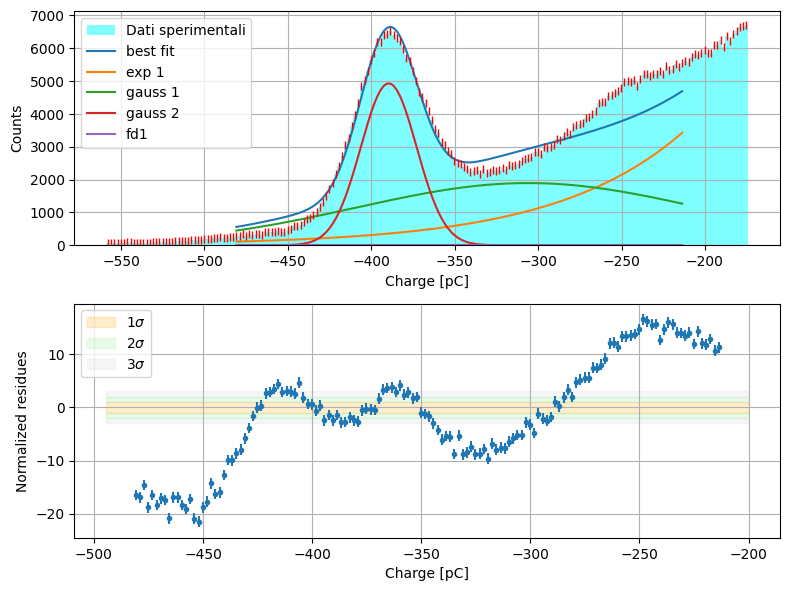

[[Model]]
    (((Model(exponential, prefix='e1_') + Model(gaussian, prefix='g1_')) + Model(gaussian, prefix='g2_')) + Model(Fermi_Dirac))
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 127
    # data points      = 140
    # variables        = 8
    chi-square         = 14026.8503
    reduced chi-square = 106.264017
    Akaike info crit   = 660.992072
    Bayesian info crit = 684.525211
    R-squared          = 0.99996949
##  Warning: uncertainties could not be estimated:
    fd_A:          at initial value
[[Variables]]
    e1_amplitude:  53746.9248 == '0.11002252239374537*g1_amplitude'
    e1_decay:     -77.59598 (fixed)
    g1_amplitude:  488508.385 (init = 469871.1)
    g1_center:    -305.889 (fixed)
    g1_sigma:      102.9573 (fixed)
    g1_fwhm:       242.445990 == '2.3548200*g1_sigma'
    g1_height:     1892.88758 == '0.3989423*g1_amplitude/max(1e-15, g1_sigma)'
    g2_amplitude:  206600.363 (init = 5000)
    g2_center:    -389.538169 (init = -350)


In [299]:
params.update(result.params)


params["g1_sigma"].vary = False   #Blocco i parametri dell'esponenziale e della prima gaussiana
params["g1_center"].vary = False  #lasciando libere le ampiezze
params["e1_decay"].vary = False
params["fd_B"].vary = False

params["g2_amplitude"].vary = True  #Sblocco i parametri di Fermi Dirac e seconda gaussiana
params["g2_center"].vary = True
params["g2_sigma"].vary = True

params["g2_amplitude"].value = 5000     #Parametri da aggiustare to make the magic happen
params["g2_center"].min = -500          #Si possono, se serve, specificare canale per canale
params["g2_center"].max = -300
params["g2_center"].set(value = -350)
params["g2_sigma"].set(value = 1)
params["g2_amplitude"].min=0
params["g1_amplitude"].min=0
params["e1_amplitude"].min=0
params["e1_amplitude"].expr=str(frac)+'*g1_amplitude'


params["fd_A"].vary = True
params["fd_B"].vary = True
params["fd_x0"].vary = True
params["fd_kt"].vary = True
params["fd_A"].min=0
params["fd_A"].max=1000
params["fd_kt"].max=0
params["fd_kt"].min=-100
params["fd_x0"].min=-500
params["fd_x0"].max=-100

model = exp1 + gauss1 + gauss2 + fd1

#params.update(fd1.guess(binCs, x=centersCs)) #Aggiorno i parametri della seconda gaussiana indovinando
params.pretty_print()

start=int(Nbin *20 / 100)
stop=int(Nbin * 90 /100)

# Fit the model to the data
result = model.fit(binCs[start:stop], params, x = centersCs[start:stop], weights = 1 / errCs[start:stop])


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.hist(chargeCs, bins = Nbin, range = lims, color = "cyan", alpha = 0.5, label = "Dati sperimentali")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.errorbar(centersCs, binCs, errCs, color = "red", fmt='|', linewidth=.6)
ax1.plot(centersCs[start:stop], result.best_fit, label='best fit')
ax1.plot(centersCs[start:stop], comps['e1_'], label='exp 1')
ax1.plot(centersCs[start:stop], comps['g1_'], label='gauss 1')
ax1.plot(centersCs[start:stop], comps['g2_'], label='gauss 2')
ax1.plot(centersCs[start:stop], comps['Fermi_Dirac'], label='fd1')
#ax1.plot(centersCs[start:stop], Fermi_Dirac(centersCs[start:stop], 2000, 1, -250, -100))


ax1.legend()
ax1.grid()

residueCs = binCs[start:stop] - result.best_fit
norm_resCs = residueCs / errCs[start:stop]

ax2.errorbar(centersCs[start:stop], norm_resCs, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()

# Print fit statistics and parameter values
print(result.fit_report())



trash

In [ ]:
exp1   = ExponentialModel(prefix='e1_') #Esponenziale 
gauss1 = GaussianModel(prefix='g1_')    #Gaussiana
gauss2 = GaussianModel(prefix='g2_')    #Gaussiana
#fd1    = ThermalDistributionModel(form = "fermi", prefix = "fd1_") #Fermi Dirac

def Fermi_Dirac(x, fd_A, fd_B,fd_x0, fd_kt):
    # Calculate model values using the parameters
    model_values = fd_A/(1+fd_B*np.exp((x-fd_x0)/fd_kt))
    return model_values

fd1=Model(Fermi_Dirac)

 
params = exp1.guess(binN, x=centersN)           #Inizializzo i parametri dell'esponenziale
params.update(gauss1.guess(binN, x=centersN))   #Indovina i parametri della prima gaussiana
params.update(gauss2.make_params(amplitude = 0, center = -320, sigma = 25)) #Imposta la seconda gaussiana con A = 0 (necessario per primo fit)
#params.update(fd1.make_params(amplitude = 0, center = -200, kt =-0.01))     #Imposta la Fermi Dirac con A = 0 (necessario per primo fit)

params["g2_amplitude"].vary = False    #Blocco i parametri della seconda gaussiana e della 
params["g2_center"].vary = False       #Fermi Dirac: non servono nel primo fit
params["g2_sigma"].vary = False
params.update(fd1.make_params(fd_A=200, fd_B=1, fd_x0=-200, fd_kt=-0.01))
params["fd_A"].vary = False
params["fd_B"].vary = False
params["fd_x0"].vary = False
params["fd_kt"].vary = False
#params["fd1_amplitude"].vary = False
#params["fd1_center"].vary = False
#params["fd1_kt"].vary = False




model = exp1 + gauss1 + gauss2 #+ fd1     #Per ora non usiamo la Fermi Dirac at all

# Fit the model to the data
result = model.fit(binN, params, x = centersN, weights = 1 / errN, nan_policy='omit')


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.hist(chargeN, bins = Nbin, range = lims, color = "cyan", alpha = 0.5, label = "Background")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.plot(centersN, result.best_fit, label='best fit')
ax1.plot(centersN, comps['e1_'], label='exp 1')
ax1.plot(centersN, comps['g1_'], label='gauss 1')


ax1.legend()
ax1.errorbar(centersN, binN, errN, color = "red", fmt='|', linewidth=0.5)
ax1.grid()

residueN = binN - result.best_fit
norm_resN = residueN / errN

ax2.errorbar(centersN, norm_resN, 1, ls = "", marker = ".", linewidth=.6)
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()

# Print fit statistics and parameter values
print(result.fit_report())

In [ ]:
params["g1_sigma"].vary = False   #Blocco i parametri dell'esponenziale e della prima gaussiana
params["g1_center"].vary = False  #lasciando libere le ampiezze
params["e1_decay"].vary = False

params["g2_amplitude"].vary = True  #Sblocco i parametri di Fermi Dirac e seconda gaussiana
params["g2_center"].vary = True
params["g2_sigma"].vary = True
params["fd_A"].vary = True
params["fd_B"].vary = True
params["fd_x0"].vary = True
params["fd_kt"].vary = True
#params["fd1_amplitude"].vary = True
#params["fd1_center"].vary = True
#params["fd1_kt"].vary = True


params["g2_amplitude"].value = 1000     #Parametri da aggiustare to make the magic happen
params["g2_center"].min = -400          #Si possono, se serve, specificare canale per canale
params["g2_center"].max = -300
params["g2_center"].set(value = -350)
params["g2_sigma"].set(value = 1)
params["fd_A"].min=0
params["fd_A"].max=1000
params["fd_kt"].max=0
params["fd_x0"].min=-400
params["fd_x0"].max=-100
model = exp1 + gauss1 + gauss2 #+ fd1

#params.update(fd1.guess(binCs, x=centersCs)) #Aggiorno i parametri della seconda gaussiana indovinando
params.pretty_print()

start=int(Nbin *25 / 100)
stop=int(Nbin * 95/ 100)

# Fit the model to the data
result = model.fit(binCs[start:stop], params, x = centersCs[start:stop], weights = 1 / errCs[start:stop])


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

_ = ax1.hist(chargeCs, bins = Nbin, range = lims, color = "cyan", alpha = 0.5, label = "Dati sperimentali")
ax1.set_xlabel('Charge [pC]')
ax1.set_ylabel('Counts')
ax1.legend()

comps = result.eval_components()                        #Plotto il best fit + le componenti
ax1.errorbar(centersCs, binCs, errCs, color = "red", fmt='|', linewidth=.6)
ax1.plot(centersCs[start:stop], result.best_fit, label='best fit')
ax1.plot(centersCs[start:stop], comps['e1_'], label='exp 1')
ax1.plot(centersCs[start:stop], comps['g1_'], label='gauss 1')
ax1.plot(centersCs[start:stop], comps['g2_'], label='gauss 2')
#ax1.plot(centersCs[start:stop], comps['Fermi_Dirac'], label='fd1')


ax1.legend()
ax1.grid()

residueCs = binCs[start:stop] - result.best_fit
norm_resCs = residueCs / errCs[start:stop]

ax2.errorbar(centersCs[start:stop], norm_resCs, 1, ls = "", marker = ".")
ax2.grid()

ax2.set_xlabel('Charge [pC]')
ax2.set_ylabel('Normalized residues')

xlim = ax2.get_xlim()

ax2.fill_between(xlim, [-1, -1], [1, 1], color = "orange", alpha = 0.2, label = r'$1\sigma$')
ax2.fill_between(xlim, [-2, -2], [-1, -1], color = "lightgreen", alpha = 0.2, label = r'$2\sigma$')
ax2.fill_between(xlim, [1, 1], [2, 2], color = "lightgreen", alpha = 0.2)
ax2.fill_between(xlim, [2, 2], [3, 3], color = "lightgray", alpha = 0.2, label = r'$3\sigma$')
ax2.fill_between(xlim, [-3, -3], [-2, -2], color = "lightgray", alpha = 0.2)

ax2.legend()
fig.tight_layout()
plt.show()

# Print fit statistics and parameter values
print(result.fit_report())

